<a href="https://colab.research.google.com/github/Alexandre77777/neural_networks/blob/main/4.%20%D0%9F%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B9%20%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D0%B9%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9%20%D1%81%D0%B5%D1%82%D0%B8%2C%20%D1%81%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%BC%20BatchNormalization()%20%D0%B8%20Dropout()/%D0%A2%D0%B5%D0%BC%D0%B0_%E2%84%964_%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_BatchNormalization()_%D0%B8_Dropout().ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тема №4. Регуляризация. BatchNormalization() и Dropout()

- ### **Регуляризация** в статистике, машинном обучении, теории обратных задач — метод добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Эта информация часто имеет вид штрафа за сложность модели. Например, это могут быть ограничения гладкости результирующей функции или ограничения по норме векторного пространства. #

### Повторение

#### Обучение по батчам

Мы уже знаем, что нейросети обучаются с помощью алгоритма обратного распространения ошибки (backpropagation), который основан на градиентном спуске. Его суть в том, чтобы последовательно изменять значения параметров нейрости, используя подсчет частных производных лосса $L$ по параметрам сети $\frac{\partial L}{\partial w_i}$.

**Вспомним, как выглядит идея алгоритма обучения нейросети:**

Пусть у нас есть нейросеть $F$, датасет из $n$ элементов $\{X_i, Y_i\}_{i=0}^n$ и лосс-функция $loss$. Тогда наша задача — найти такие значения весов нейросети, чтобы значение лосс-функции $loss$ в среднем для всех элементов датасета было маленьким:

$$L = \frac{∑^{n}_{i=1} loss(y_i, \widehat{y}_i)}{n} \to min$$

Здесь $y_i$ — правильный ответ на i-й элементы датасета, $\widehat{y}_i$ — ответ нейросети на $i$-й элемент датасета.

Алгоритм градиентного спуска помогает находить оптимальные веса с помощью следующих идей:
- знак частной производной $\frac{\partial L}{\partial w_i}$ показывает, в какую сторону нужно сдвинуть вес $w_i$, чтобы значение лосса $L$ стало меньше;
- модуль частной производной $\frac{\partial L}{\partial w_i}$ тем больше, чем дальше значение $w_i$ от оптимального;




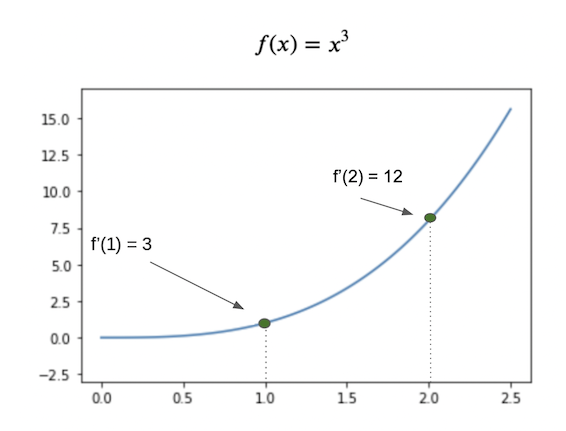

**Алгоритм градиентной оптимизации** для нейросети выглядит следующим образом:

1. Инициализируем все веса сети $W_i$ и $b_i$ случайными значениями. Выбираем значение шага градиентного спуска $\alpha$
2. Пока не будет выполнен критерий остановки, делаем следующее:
    - вычисляем значение $L$ c текущими значениями параметров $W_i$ и $b_i$;
    - вычисляем значения частных производных $\frac{\partial L}{\partial W_i}$, $\frac{\partial L}{\partial b_i}$;
    - обновляем значения параметров сети:
    $$W_i = W_i - \alpha \frac{\partial L}{\partial W_i}, \ \ b_i = b_i - \alpha \frac{\partial L}{\partial b_i}$$

Критерии остановки могут быть разные. Самый логичный и распространенный такой: останавливаемся, когда изменения лосса от итерации к итерации (или от эпохи к эпохе) стали невелики по модулю. Кроме этого, смотрим за переобучением: если началось переобучение, останавливаем алгоритм.

Теперь представим, что у нас большой датасет. Например, 1.000.000 элементов. Для такого датасета каждая итерация описанного выше алгоритма будет работать очень долго, ведь на каждой итерации придется вычислять значение выхода нейросети и лосса $L$ по всем элементам данных!
Кроме этого, может возникнуть еще и вторая проблема: датасет большого размера может не влезть в память GPU. Тогда мы в принципе не сможем сделать шаг алгоритма.

Решение такое: давайте на каждом шаге будем вычислять значение лосса $L$ и частных производных по части элементов датасета, а не по всем сразу. Например, по 100 элементам. Тогда алгоритм будет выглядеть так:

**Алгоритм градиентной оптимизации** для нейросети выглядит следующим образом:

1. Инициализируем все веса сети $W_i$ и $b_i$ случайными значениями. Выбираем значение шага градиентного спуска $\alpha$
2. Пока не будет выполнен критерий остановки, делаем следующее:
    - Разбиваем данные на **батчи** по $k$ элементов в каждом. Для каждого бача делаем следующее:
        - вычисляем значение $L^j$ c текущими значениями параметров $W_i$ и $b_i$ по элементам текущего $j$-го батча;
        - вычисляем значения частных производных $\frac{\partial L^j}{\partial W_i}$, $\frac{\partial L^j}{\partial b_i}$;
        - Обновляем значения параметров сети:
        $$W_i = W_i - \alpha \frac{\partial L^j}{\partial W_i}, \ \ b_i = b_i - \alpha \frac{\partial L^j}{\partial b_i}$$

Такой алгоритм называется **градиентным спуском по мини-батчам** (mini-batch gradient descent) или **стохастическим градиентным спуском** (stochastic gradient descent, SGD).

Каждая итерация такого алгоритма работает намного быстрее, чем каждая итерация обычного градиентного спуска, где мы каждый раз вычисляли значение $L$ по всем элементам датасета. Но общее количество итераций, которое требуется стохастическому градиентному спуску, получается больше.

Чтобы понять, что имеется в виду, рассмотрим крайний случай, когда размер батча равен единице. То есть, когда на каждой итерации градиентного спуска мы вычисляем значение выражения $L$ и частные производные только на основе одного элемента датасета. Это значит, что на каждом шаге алгоритма мы будем сдвигать веса сети так, чтобы сеть начинала выдавать лучшие ответы именно на текущий элемент $y_i$. Но это направление изменения весов не обязательно точно совпадает с тем, которое ведет к улучшению результатов сети на всех элементах датасета.

Получается, стохастический градиентный спуск на каждом шаге будет двигать значения параметров в направлении, чуть отклоняющемся от идеального.


Проиллюстрировать это можно так:

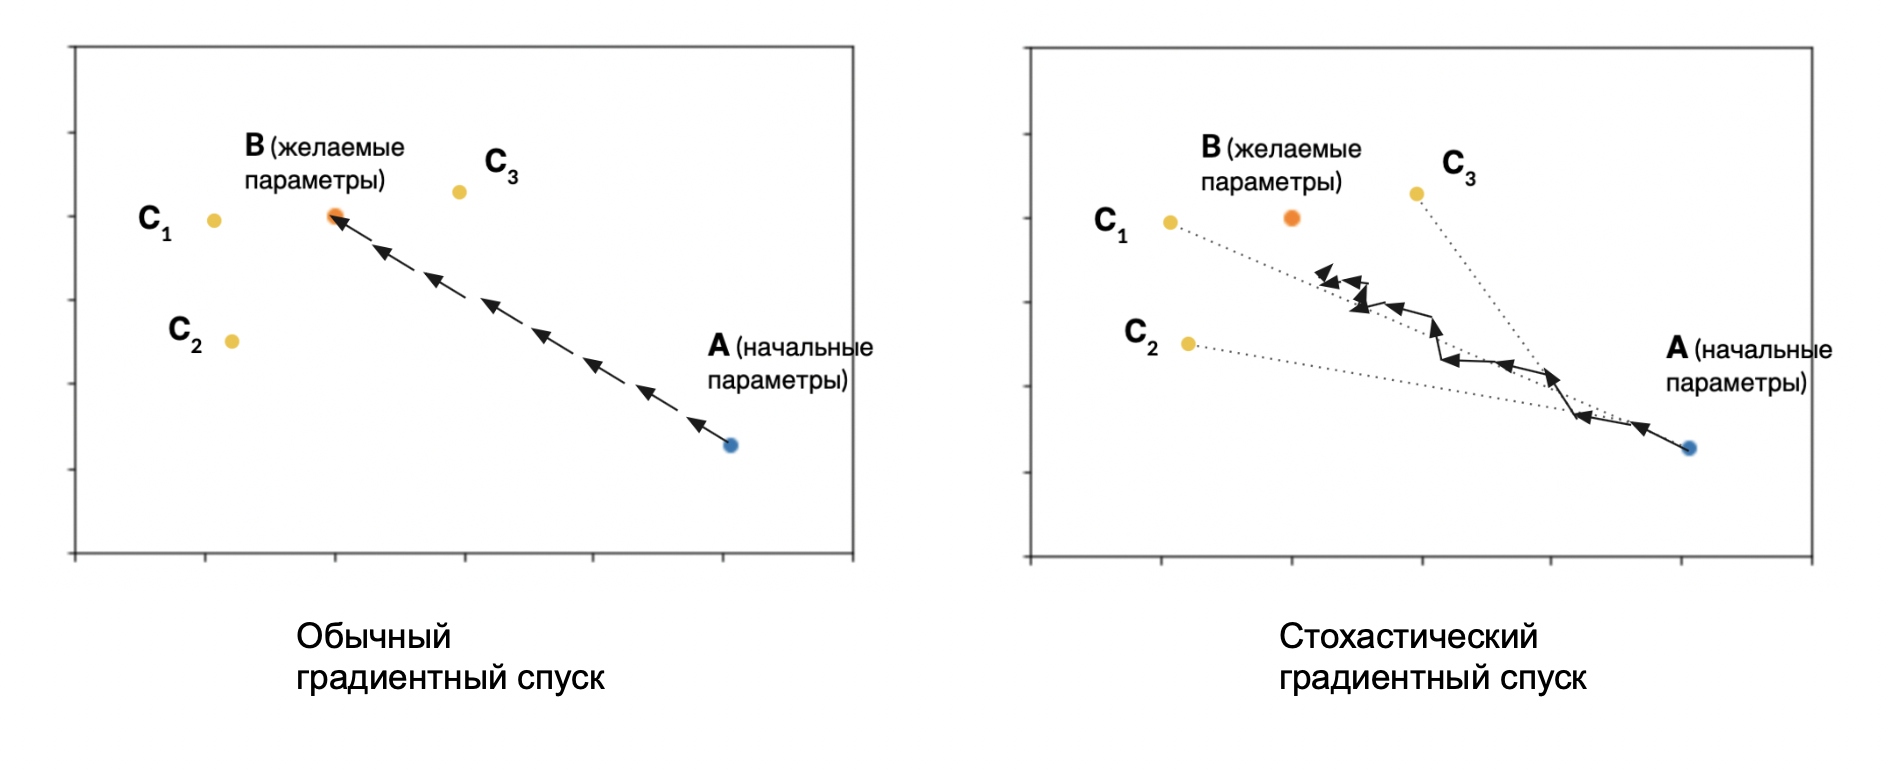

Здесь $B$ — вектор тех значений параметров, при которых среднее значение лосса на элементах датасета минимально. То есть, это те значения параметров, к которым мы хотим прийти в результате обучения сети.
$С_i$ — векторы значений параметров сети, при которых значение лосса на $i$-ом элементе датасета минимально.


#### Нормализация входов сети

Для нейросетей полезно нормализовать входные данные перед подачей в сеть. Нормализация — это приведение распределений всех входящих признаков к одному масштабу.

Например, пусть у нас есть задача определения кредитного скоринга по информации о клиенте. Пусть информация включает в себя возраст клиента. Этот признак варьируется в значениях [18, 80], т.е. в довольно больших масштабах, его значения по модулю могут быть довольно велики. Это делает алгоритм градиентного спуска менее эффективным: приводит к необходимости большего количества итераций для обучения сети, а также может вызывать другие проблемы, такие как взрыв градиентов в сети.

Самый распространенный способ нормализации — **стандартизация**. Это приведение к среднему 0 и дисперсии 1.

Пусть у нас есть признак $F$, и его значения в датасете $\{x_i^f\}$. Тогда значение признака каждого элемента изменяется следующим образом:
$$\frac{x_i^f-\mu_f}{\sigma_f}$$

, где $\mu_f$ — среднее значение признака $F$ по датасету, $\sigma_f$ — стандартное отклонение признака $F$ по датасету. После такой нормализации среднее значение признака по датасету будет 0, стандартное отклонение — 1.



Проиллюстрировать нормализацию признаков можно так. Пусть в датасете два признака. Визуализируем элементы датасета точками на плоскости.

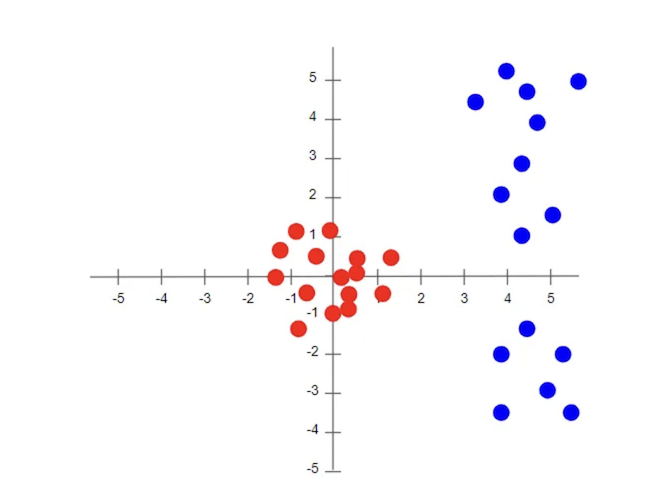

Синие точки здесь иллюстрируют элементы датасета до нормализации, красным — после.

### BatchNorm

Сейчас мы поговорим о новом слое сети — батч-нормализации. **Это слой, который помогает сделать обучение сети более стабильным и более быстрым.** Кроме того, часто нейросеть со слоями batchnorm может обучиться под задачу лучше, чем та же сеть без batchnorm.





Посмотрим на нейросеть, у которой несколько слоев. Заметим, что 2-3 слои этой нейросети можно рассматривать как отдельную, меньшую нейросеть. Входные данные в эту нейросеть — выходы первого слоя сети.

Мы уже знаем, что для лучшего обучения нейросетей входные данные нужно нормализовать. Получается, нормализация выходов каждого промежуточно слоя тоже способствует лучшему обучению сети. BatchNorm — это и есть слой, который выполняет такую нормализацию.

network.svg



Но есть еще вторая причина нормализовать выходы промежуточных слоев. Это эффект internal covariate shift в нейросетях. Изначально BatchNorm задумывался как способ избавиться отэтого эффекта.

**Что такое internal covariate shift**: посмотрим на нейросеть, у которой несколько слоев. Во время обучения все слои обучаются совместно. И каждый слой сети во время обучения должен подстроиться под те значения, которые выдает предыдущий слой. Однако во время обучения сети распределения значений, которые выдает каждый слой сети, меняются. И каждому скрытому слою на каждой итерации алгоритма приходится подстраиваться под новое распределение выходов предыдущего слоя. Из-за этого сеть обучается медленнее. При этом на каждой итерации обучения веса могут меняться довольно сильно, что может провоцировать другие проблемы, например, взрыв градиентов.

Нормализация выходов слоев нейросети помогла бы решить эту проблему.

Итак, как можно реализовать нормализацию выходов слоев? Самая простая идея — строго нормализовать выход каждого слоя перед подачей в сеть дальше, как мы нормализуем входные данные. Скажем, так же приводить средние значения всех выходов слоев к 0, а дисперсии к 1.

Но почему бы не дать нейросети больше свободы и не позволить ей самой определять, как именно лучше всего нормализовать выходы каждого слоя?
Именно в этом и есть идея BatchNorm. **BatchNorm — это обучаемый слой, который нормализует выходы сети с помощью обучаемых параметров**.


> Дисперсия – это среднее арифметическое от квадратов отклонений значений от среднего. Отражает меру разброса данных вокруг средней арифметической.

Слой BatchNorm применяется после слоя сети и работает следующим образом:

1. Считаем среднее $\mu_B$ и дисперсию $\sigma_B$ выходов сети слоя по батчу. То есть, у нас есть $b$ выходов слоя $\{x_i\}_{i=1}^b$, где $b$ — размер батча. Тогда:

$$\mu_B = \frac{\sum_{i=1}^b x_i}{b}$$
$$\sigma^2_B = \frac{\sum_{i=1}^b (x_i - \mu_B)^2}{b}$$

2. Нормализуем выходы слоя:
$$\widehat{x_i} = \frac{x_i - \mu_B}{\sigma_B}$$

3. Вычисляем обновленные выходы слоя как

$$y_i = \gamma\widehat{x_i} + \beta$$

, где $\gamma$ и $\beta$ — обучаемые параметры.


То есть, идея такая: мы нормализуем выход каждого нейрона так, чтобы среднее значение его выхода стало 0, дисперсия 1. И затем мы умножаем выход каждого нейрона на обучаемое значение $\gamma$ и прибавляем обучаемое значение $\beta$. То есть, мы изменяем среднее значение выхода нейрона и его дисперсию. Но при этом делаем так, что для всех нейронов слоя среднее значение выхода и дисперсия были одинаковы.

Обучаемые среднее и дисперсия для каждого слоя позволяют нейросети выбирать наиболее удобную нормализацию значений слоев для конкретной задачи.

На практике BatchNorm применяется практически во всех нейросетях, особенно в глубоких. Мы еще это увидим, когда будем говорить о популярных архитектурах сетей.

## Пример

- Рассмотрим на практике применение BatchNormalition() и Dropout(), в процессе обучения моделей для классификации MNIST:

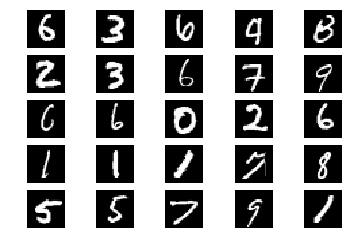

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
from pylab import rcParams
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

### Распределение и нормализация исходных данных

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train = X_train.reshape((X_train.shape[0],
                           X_train.shape[1],
                           X_train.shape[2],
                           1))
X_train = X_train/ 255.0

In [ ]:
X_test = X_test.reshape((X_test.shape[0],
                         X_test.shape[1],
                         X_test.shape[2], 1))
X_test = X_test/ 255.0

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Модель №1 (BatchNormalization() и Dropout() не используется)

In [ ]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(64, (3,3), activation="relu"))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(64, (3,3), activation="relu"))
model_1.add(Flatten())
model_1.add(Dense(64, activation="relu"))
model_1.add(Dense(10, activation="softmax"))
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs = 5

In [ ]:
model_1_history = model_1.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(X_test, y_test))

Epoch 1/5
469/469 [==============================] - 63s 132ms/step - loss: 0.2491 - accuracy: 0.9223 - val_loss: 0.0605 - val_accuracy: 0.9811
Epoch 2/5
469/469 [==============================] - 46s 98ms/step - loss: 0.0579 - accuracy: 0.9822 - val_loss: 0.0443 - val_accuracy: 0.9855
Epoch 3/5
469/469 [==============================] - 47s 100ms/step - loss: 0.0414 - accuracy: 0.9872 - val_loss: 0.0429 - val_accuracy: 0.9855
Epoch 4/5
469/469 [==============================] - 48s 102ms/step - loss: 0.0314 - accuracy: 0.9898 - val_loss: 0.0286 - val_accuracy: 0.9910
Epoch 5/5
469/469 [==============================] - 46s 99ms/step - loss: 0.0266 - accuracy: 0.9912 - val_loss: 0.0273 - val_accuracy: 0.9913


### Модель №2 (с использованием BatchNormalization())

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(64, (3,3), activation="relu"))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(64, (3,3), activation="relu"))
model_2.add(Flatten())
model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(Activation("relu"))
model_2.add(Dense(10))
model_2.add(BatchNormalization())
model_2.add(Activation("softmax"))

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_2_history = model_2.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(X_test, y_test))

Epoch 1/5
469/469 [==============================] - 52s 106ms/step - loss: 0.3566 - accuracy: 0.9631 - val_loss: 0.4118 - val_accuracy: 0.9860
Epoch 2/5
469/469 [==============================] - 46s 98ms/step - loss: 0.1414 - accuracy: 0.9892 - val_loss: 0.1079 - val_accuracy: 0.9913
Epoch 3/5
469/469 [==============================] - 48s 102ms/step - loss: 0.0842 - accuracy: 0.9925 - val_loss: 0.0626 - val_accuracy: 0.9915
Epoch 4/5
469/469 [==============================] - 47s 100ms/step - loss: 0.0578 - accuracy: 0.9943 - val_loss: 0.0628 - val_accuracy: 0.9889
Epoch 5/5
469/469 [==============================] - 46s 99ms/step - loss: 0.0420 - accuracy: 0.9957 - val_loss: 0.0509 - val_accuracy: 0.9906


### Визуализация

In [ ]:
plt.plot(model_1_history.history['accuracy'])
plt.plot(model_2_history.history['accuracy'])
plt.plot(model_1_history.history['val_accuracy'])
plt.plot(model_2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Model 1 Training','Model with Batch Normalization Training',
            'Model 1 Testing', 'Model with Batch Normalization Testing'],
           loc='center right')

## Dropout

Дропаут это еще один необычный слой, который используется в нейронных сетях. У него есть один гиперпараметр $p$.

Идея дропаута состоит в том, что во время обучения мы зануляем случайную часть входа и отдаем вход дальше (для каждого числа мы подбрасываем монетку и с вероятностью $p$ зануляем это число).

Дропаут позволяет тренировать более устойчивые сети и избегать переобучения.

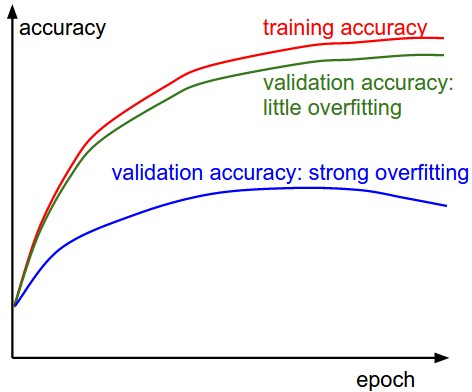

**Возможные действия при переобучении:**
1. Увеличение количества данных в наборе;
2. Уменьшение количества параметров модели;
3. Добавление регуляризации / увеличение коэффициента регуляризации.
**Возможные действия при недообучении:**
1. Добавление новых параметров модели;
2. Использование для описания модели функций с более высокой степенью;
3. Уменьшение коэффициента регуляризации.

### Dropout, механика работы.

Как мы сказали выше, dropout зануляет случайную часть входов и отдает их дальше. Допустим $p=0.5$ (достаточное популярное значение). Тогда мы просто убираем половину всего входа! Такое сильное воздействие явно плохо повлияет на качество нашей модели, поэтому мы делаем зануление только во время обучения.

**Во время обучения**: для каждого числа во входе подбрасываем монетку и зануляем его с вероятностью $p$. Выход умножаем на $\frac{1}{1-p}$, чтобы дисперсия выходов осталось такой же, как и на входе.

**Во время предсказаний**: ничего не делаем).

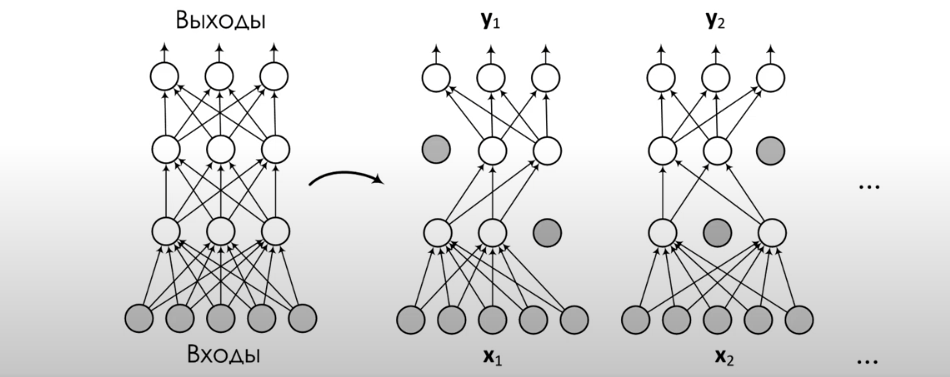

### Dropout, что дает?

* Сеть выучивает более устойчивые представления на внутренних слоях.
* Сильно увеличивает число итераций, которые нужны для сходимости.
* Можно получить интерпретацию, которая говорит, что дропаут усредняет выходы большо числа нейросетей с $p|W|$ нейронами на предыдущем слоев.

Дропаут вызывает интересный эффект: в начале обучения качество на тестовом датасете выше, чем на обучающем. Потому что для обучающего датасета у нас есть зануление, которое сильно портит предсказания.

## Пример

### Модель №3 (с использованием Dropout())

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), activation="relu"))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(64, (3,3), activation="relu"))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(64, (3,3), activation="relu"))
model_3.add(Flatten())
model_3.add(Dense(64))
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(10))
model_3.add(Activation("softmax"))

model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_3_history = model_3.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=15,
                              verbose=1,
                              validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 49s 102ms/step - loss: 0.3715 - accuracy: 0.8851 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 2/15
469/469 [==============================] - 47s 100ms/step - loss: 0.1044 - accuracy: 0.9702 - val_loss: 0.0407 - val_accuracy: 0.9868
Epoch 3/15
469/469 [==============================] - 47s 100ms/step - loss: 0.0772 - accuracy: 0.9777 - val_loss: 0.0316 - val_accuracy: 0.9896
Epoch 4/15
469/469 [==============================] - 47s 101ms/step - loss: 0.0612 - accuracy: 0.9825 - val_loss: 0.0267 - val_accuracy: 0.9916
Epoch 5/15
469/469 [==============================] - 47s 99ms/step - loss: 0.0522 - accuracy: 0.9851 - val_loss: 0.0253 - val_accuracy: 0.9925
Epoch 6/15
469/469 [==============================] - 47s 99ms/step - loss: 0.0447 - accuracy: 0.9874 - val_loss: 0.0260 - val_accuracy: 0.9920
Epoch 7/15
469/469 [==============================] - 47s 101ms/step - loss: 0.0391 - accuracy: 0.9888 - val_loss: 0.0301 - val_accu

### Визуализация

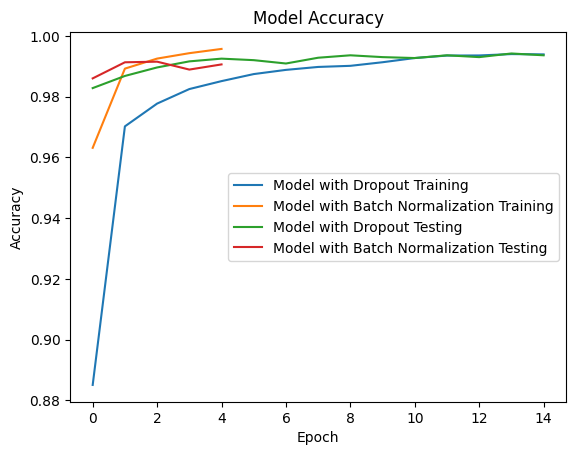

In [ ]:
plt.plot(model_3_history.history['accuracy'])
plt.plot(model_2_history.history['accuracy'])
plt.plot(model_3_history.history['val_accuracy'])
plt.plot(model_2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Model with Dropout Training','Model with Batch Normalization Training',
            'Model with Dropout Testing', 'Model with Batch Normalization Testing'],
           loc='center right')

### Dropout, взаимодействие с BatchNorm.

Вы можете использовать вместе batchnorm и dropout, однако порядок их применения может иметь влияние на производительность и качество сети.

Согласно [исследованиям](https://arxiv.org/abs/1905.05928), batchnorm должен быть добавлен после после сверточных/полносвязных слоев, но перед ReLu (или другой функцией активации). Dropout должен быть применен после функции активации слоя.

Таким образом, порядок использования batchnorm и dropout может быть:

    • -> Conv/FC
    • -> BatchNorm
    • -> ReLu (или другая функция активации)
    • -> Dropout
    • -> Conv/FC

[Эксперименты с BatchNorm и Dropout пользователей StackOverFlow](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout)

[99.5% MNIST (Keras) using BatchNorm and Dropout](https://www.kaggle.com/code/pip33eeed/99-5-mnist-keras-data-aug-batchnorm/notebook)

In [ ]:
model_4 = Sequential()
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(Dropout(0.25))
model_4.add(MaxPooling2D((2, 2)))
model_4.add(Conv2D(64, (3,3), activation="relu"))
model_4.add(MaxPooling2D((2, 2)))
model_4.add(Conv2D(64, (3,3), activation="relu"))
model_4.add(Dropout(0.25))
model_4.add(Flatten())
model_4.add(Dense(64))
model_4.add(BatchNormalization())
model_4.add(Activation("relu"))
model_4.add(Dense(10))
model_4.add(BatchNormalization())
model_4.add(Activation("softmax"))

model_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_4_history = model_4.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=15,
                              verbose=1,
                              validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 61s 126ms/step - loss: 0.4172 - accuracy: 0.9448 - val_loss: 0.3875 - val_accuracy: 0.9846
Epoch 2/15
469/469 [==============================] - 62s 131ms/step - loss: 0.1587 - accuracy: 0.9843 - val_loss: 0.1171 - val_accuracy: 0.9878
Epoch 3/15
469/469 [==============================] - 58s 124ms/step - loss: 0.1001 - accuracy: 0.9877 - val_loss: 0.0703 - val_accuracy: 0.9915
Epoch 4/15
469/469 [==============================] - 58s 123ms/step - loss: 0.0709 - accuracy: 0.9897 - val_loss: 0.0457 - val_accuracy: 0.9924
Epoch 5/15
469/469 [==============================] - 59s 126ms/step - loss: 0.0525 - accuracy: 0.9920 - val_loss: 0.0398 - val_accuracy: 0.9933
Epoch 6/15
469/469 [==============================] - 58s 124ms/step - loss: 0.0432 - accuracy: 0.9927 - val_loss: 0.0352 - val_accuracy: 0.9923
Epoch 7/15
469/469 [==============================] - 58s 125ms/step - loss: 0.0350 - accuracy: 0.9936 - val_loss: 0.0291 - val_ac

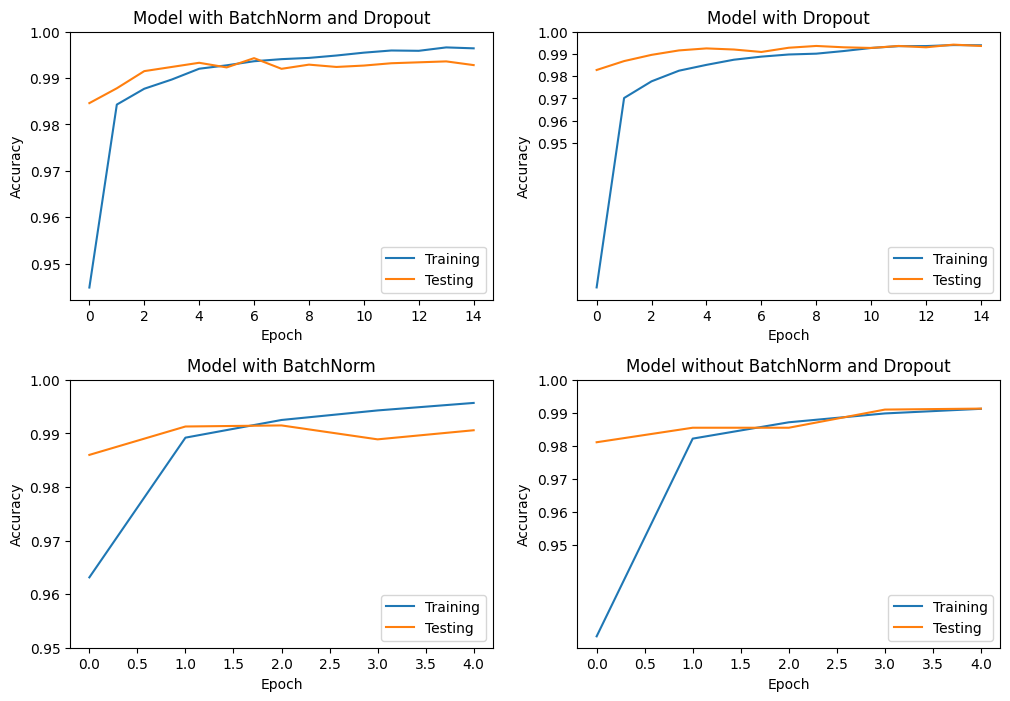

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_4_history.history['accuracy'], label='Training')
plt.plot(model_4_history.history['val_accuracy'], label='Testing')
plt.title('Model with BatchNorm and Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1])

plt.subplot(2, 2, 2)
plt.plot(model_3_history.history['accuracy'], label='Training')
plt.plot(model_3_history.history['val_accuracy'], label='Testing')
plt.title('Model with Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1])

plt.subplot(2, 2, 3)
plt.plot(model_2_history.history['accuracy'], label='Training')
plt.plot(model_2_history.history['val_accuracy'], label='Testing')
plt.title('Model with BatchNorm')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1])

plt.subplot(2, 2, 4)
plt.plot(model_1_history.history['accuracy'], label='Training')
plt.plot(model_1_history.history['val_accuracy'], label='Testing')
plt.title('Model without BatchNorm and Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1])

plt.subplots_adjust(hspace=0.3)

plt.show()

### Визуализируем карты активаций:

Функция позволяет увидеть, как модель Keras "видит" изображение, проходя через все ее слои. Она берет обученную модель и конкретное изображение, а затем показывает, как информация о нем меняется на каждом этапе обработки.

Представьте, что вы смотрите на картину через увеличительное стекло. Сначала вы видите только общую картину, но чем сильнее увеличиваете, тем больше деталей вы замечаете. Эта функция работает примерно также: она показывает, как модель "увеличивает" изображение, фокусируясь на разных его аспектах на каждом слое.

**Вот как это работает:**

1. **Выбираем модель и изображение.**
2. **Создаем "модель активаций",** которая отслеживает, как информация преобразуется в каждом слое.
3. **Прогоняем изображение через "модель активаций".**
4. **Визуализируем активации:**
    * **Разбиваем активации на "каналы".**
    * **Нормализуем и масштабируем каждый канал.**
    * **Отображаем каналы в виде сетки.**
    * **Добавляем границы между каналами.**
5. **Смотрим на сетки активаций** и видим, как модель "видит" изображение.


In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def visualize_act_map(model, img):
  """
  Функция для визуализации активаций слоев модели Keras в последовательном порядке

  Args:
      model: Обученная модель Keras
      img: Изображение, преобразованное в тензор

  Returns:
      None. Визуализирует активации интересующих слоев в последовательном порядке.
  """
  # Создаем модель для активаций
  layer_outputs = [layer.output for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D))]
  activation_model = Model(inputs=model.input, outputs=layer_outputs)

  # Получаем активации
  activations = activation_model.predict(img)

  # Визуализация активаций
  for layer_activation, layer in zip(activations, model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D)):
      n_features = layer_activation.shape[-1]
      size = layer_activation.shape[1]
      n_cols = n_features // 16 + int(n_features % 16 > 0)
      display_grid = np.zeros((size * n_cols, size * 16))

      for col in range(n_cols):
        for row in range(16):
            if col * 16 + row < n_features:  # Проверяем, что индекс не выходит за границы
              channel_image = layer_activation[0, :, :, col * 16 + row]
              channel_image -= channel_image.mean()
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

      scale = 1. / size
      fig, ax = plt.subplots(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
      ax.set_title(layer.name)
      ax.grid(False)
      # Используем imshow для отображения изображений
      ax.imshow(display_grid, aspect='auto', cmap='viridis')

      # Создаем границы между плитками
      for i in range(1, n_cols):
        ax.axhline(y=i * size - 0.5, color='white', linewidth=2)
      for i in range(1, 16):
        ax.axvline(x=i * size - 0.5, color='white', linewidth=2)

      plt.show()

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def visualize_act_map(model, img):
  """
  Функция для визуализации активаций слоев модели Keras в последовательном порядке

  Args:
      model: Обученная модель Keras
      img: Изображение, преобразованное в тензор

  Returns:
      None. Визуализирует активации интересующих слоев в последовательном порядке.
  """
  # Создаем модель для активаций
  layer_outputs = [layer.output for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D))]
  activation_model = Model(inputs=model.input, outputs=layer_outputs)

  # Получаем активации
  activations = activation_model.predict(img)

  # Визуализация активаций
  for layer_activation, layer in zip(activations, model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D)):
      n_features = layer_activation.shape[-1]
      size = layer_activation.shape[1]
      n_cols = n_features // 16 + int(n_features % 16 > 0)
      display_grid = np.zeros((size * n_cols, size * 16))

      for col in range(n_cols):
        for row in range(16):
            if col * 16 + row < n_features:  # Проверяем, что индекс не выходит за границы
              channel_image = layer_activation[0, :, :, col * 16 + row]
              channel_image -= channel_image.mean()

              # Добавлено исправление для RuntimeWarning: invalid value encountered in divide
              if channel_image.std() == 0:
                channel_image += 1*(10**8)

              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128

              # Добавлено исправление для RuntimeWarning: invalid value encountered in cast
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')

              display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

      scale = 1. / size
      fig, ax = plt.subplots(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
      ax.set_title(layer.name)
      ax.grid(False)
      # Используем imshow для отображения изображений
      ax.imshow(display_grid, aspect='auto', cmap='viridis')

      # Создаем границы между плитками
      for i in range(1, n_cols):
        ax.axhline(y=i * size - 0.5, color='white', linewidth=2)
      for i in range(1, 16):
        ax.axvline(x=i * size - 0.5, color='white', linewidth=2)

      plt.show()

**В итоге:**

* Мы можем увидеть, как модель "распознает" различные элементы изображения.
* Мы можем понять, как модель принимает решение о классификации изображения.
* Это помогает нам улучшить модель, изменив ее архитектуру или параметры.

**Пример:**

Представьте, что у нас есть модель, которая классифицирует изображения кошек и собак. Мы можем использовать эту функцию, чтобы увидеть, как модель "видит" изображение кошки.

* На первых слоях мы увидим активации, которые представляют собой общие характеристики изображения, такие как края и цвета.
* На более глубоких слоях мы увидим активации, которые представляют собой более сложные характеристики, такие как уши, усы и глаза кошки.

313/313 [==============================] - 5s 14ms/step


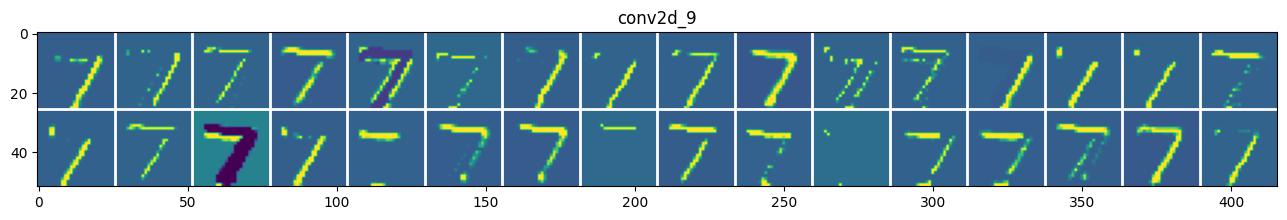

<ipython-input-20-b43e3ff9e433>:42: RuntimeWarning: divide by zero encountered in divide
  channel_image /= channel_image.std()


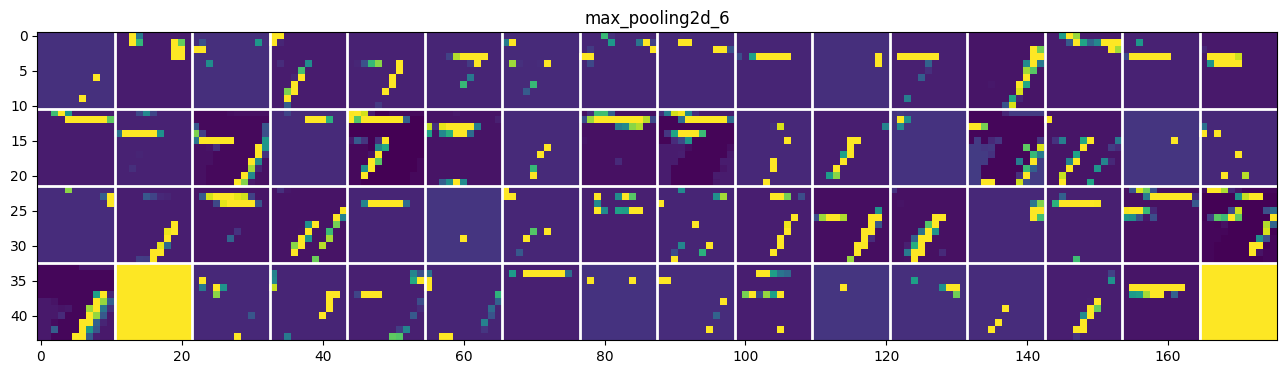

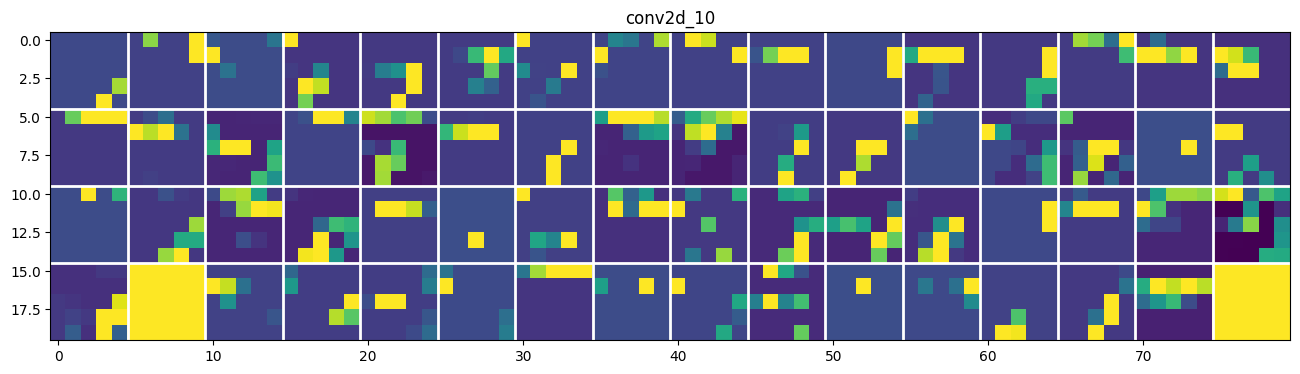

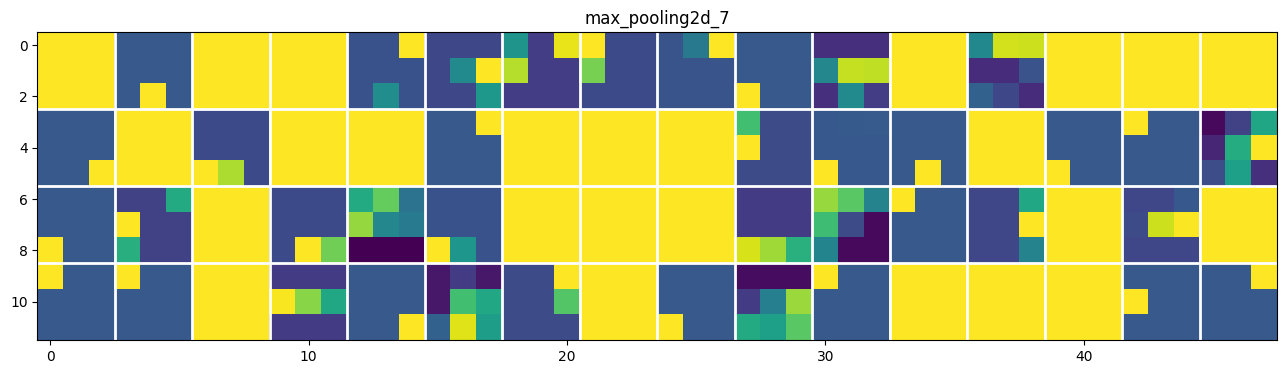

In [ ]:
# Вызов функции для визуализации картактиваций слоев
visualize_act_map(model_4, X_test)

### [Практическая работа №4. Построение сверточной нейронной сети для классификации изображений из датасета CIFAR-100, с использованием BatchNormalization() и Dropout()](https://colab.research.google.com/drive/1xOXzXGPK07bf37INmCjQEfN-qYSAnCbL#scrollTo=5FTzd6Tr1HE6)



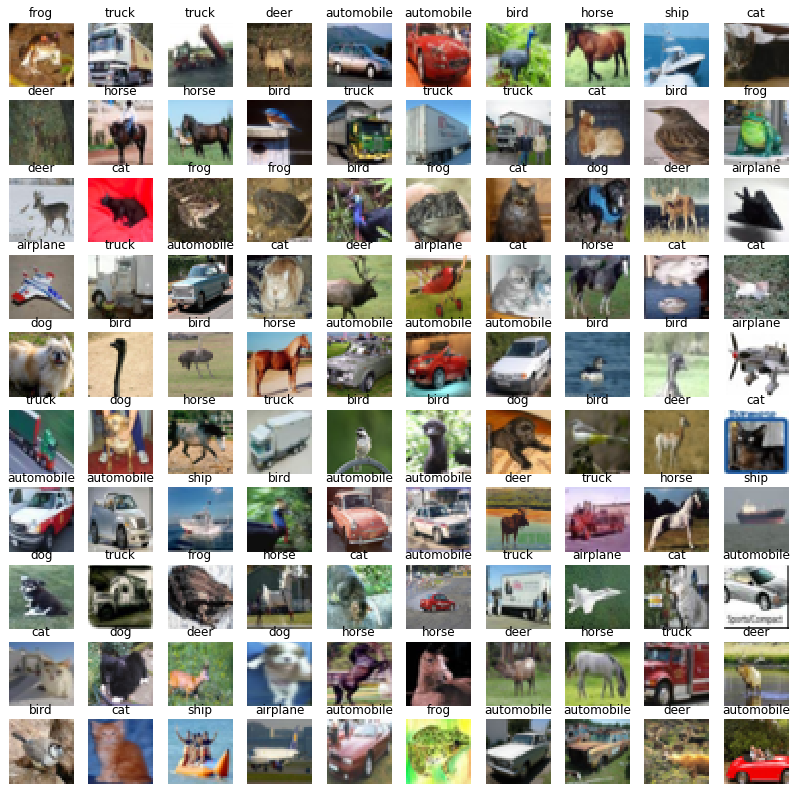